# PART 01: PREPROCESSING SPOT IMAGE AND LAND USE DATA FOR FINETUNING

## Introduction
This notebook guides you through preprocessing SPOT satellite imagery and corresponding Land use (LU) map to prepare a dataset for fine-tuning the Prithvi model. The steps include  visualizing data, stacking image bands, calculating spectral indices, cropping images, creating patches, and splitting data into training, validation, and testing sets.

This notebook provides a hands-on guide to preprocessing SPOT satellite imagery and Land use map to create a dataset for fine-tuning the Prithvi model. The preprocessing pipeline includes visualizing Land use map, calculating spectral indices (NDVI and NDWI) and stacking multi-temporal SPOT image bands, cropping images to a common extent, generating patches, and splitting the dataset into training, validation, and testing sets. 

## Main Objective
To preprocess SPOT satellite imagery and Land use map to produce a dataset suitable for fine-tuning the Prithvi model for accurate land use classification.

## Specific Objectives
By the end of this module, learners will be able to:

- Visualize a Land use map and interpret its attribute table to understand land cover classes.
- Compute spectral indices (NDVI, NDWI) and stack SPOT image bands from multiple years (2016, 2020, 2022).
- Crop the stacked SPOT imagery to align with the Land use data extent, ensuring spatial consistency for analysis.
- Generate fixed-size image and label patches (e.g., 224x224 pixels, 112x112 pixels) from SPOT and Land use map for Prithvi model compatibility.
- Split the dataset into training (70%), validation (10%), and testing (20%) sets to support model development and evaluation.

## Prerequisites
To follow this module, learners should have:
- Basic understanding of remote sensing and Geographic Information Systems (GIS) concepts (e.g., satellite imagery, coordinate systems).
- Familiarity with geospatial data formats (e.g., GeoTIFF for rasters, Shapefile for vectors).
- Basic Python programming skills and familiarity with libraries like Rasterio, Geopandas, NumPy, and Matplotlib. Advanced Python expertise is not required.
- A Python environment with required libraries installed (see setup instructions at PART 00).

## Required Inputs
- **SPOT Imagery**: Three SPOT images from Khon Kaen, Thailand (2016, 2020, 2022), each with 6 bands (e.g., Red, Green, Blue, NIR, NDVI, and NDWI)
- **Land Use Data**: A Land use shapefile (e.g. gt_LU2022A.shp) matching the SPOT imagery’s extent.
- **Python Environment**: Installed with packages including `rasterio`, `geopandas`, `numpy`, `matplotlib`, and `tqdm`.

**Important Notes**:
1. This module uses sample data from Khon Kaen, Thailand. For larger regions, create a mosaic of SPOT images before preprocessing.
2. Ensure SPOT imagery and Land Use data share the same CRS to avoid spatial misalignment during processing.
3. This notebook assumes access to the sample data paths provided (e.g., `/home/jovyan/shared/2025_THA_LDD_training/SPOT/A/`). Adjust paths as needed for your environment.

## Step 1: Visualizing the Land Use Map

In this step, we load and visualize the Land use map for Khon Kaen, Thailand, and examine its attribute table. The dataset includes 2 land use classes, as shown below:

| Land Use        | Raster Value | Color Code |
|-----------------|--------------|------------|
| Forest          | 1            | Green      |
| Agricultural    | 2            | Yellow     |

In [1]:
pip install geopandas

  Using cached geopandas-1.1.1-py3-none-any.whl.metadata (2.3 kB)
  Using cached pyogrio-0.11.0-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (5.3 kB)
  Using cached shapely-2.1.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
Using cached geopandas-1.1.1-py3-none-any.whl (338 kB)
Using cached pyogrio-0.11.0-cp310-cp310-manylinux_2_28_x86_64.whl (27.6 MB)
Using cached shapely-2.1.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)

[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os

# Define paths and create output directory
place_name = 'Khon_Kaen'
output_folder = place_name
os.makedirs(output_folder, exist_ok=True)

spot_images_folder_path = '/home/jovyan/shared/2025_THA_LDD_training/SPOT/A/SPOT'
lu_shp_path = '/home/jovyan/shared/2025_THA_LDD_training/SPOT/A/GT/gt_LU2022A.shp'
landuse_path = os.path.join(output_folder, 'gt_LU2022A_raster.tif')

In [3]:
import os
import pandas as pd
import geopandas as gpd

%time

# Validate shapefile existence
if not os.path.exists(lu_shp_path):
    raise FileNotFoundError(f"Shapefile not found: {lu_shp_path}")

# Define bounding box
bbox = (102.36639, 16.56754, 102.37659, 16.57427)
    
# Read shapefile
gdf = gpd.read_file(lu_shp_path)
print("No of rows:", len(gdf))
print("CRS:", gdf.crs)

# Display first 5 rows
gdf.head()

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 3.81 µs
No of rows: 2462
CRS: EPSG:32648


,OBJECTID,LU_ID_L1,LU_ID_L2,LU_ID_L3,LU_CODE,LU_DES_TH,LU_DES_EN,LUL1_CODE,LUL2_CODE,LU_DES,Shape_Area,RAI,CLASS,geometry
0,1,2.0,20.0,2001.0,A001,เกษตรผสมผสาน/ไร่นาสวนผสม,Integrated farm/Diversified farm,A,A0,None,0.007101,4,0,"POLYGON ((231497.851 1834335.859, 231454.977 1..."
1,1,2.0,20.0,2001.0,A001,เกษตรผสมผสาน/ไร่นาสวนผสม,Integrated farm/Diversified farm,A,A0,None,0.025581,16,0,"POLYGON ((230660.195 1840495.116, 230664.482 1..."
2,15,2.0,21.0,2100.0,A100,นาร้าง,Abandoned paddy field,A,A1,None,0.016422,10,0,"POLYGON ((225305.412 1829638.89, 225300.4 1829..."
3,15,2.0,21.0,2100.0,A100,นาร้าง,Abandoned paddy field,A,A1,None,0.043954,27,0,"POLYGON ((216539.782 1829843.363, 216541.543 1..."
4,15,2.0,21.0,2100.0,A100,นาร้าง,Abandoned paddy field,A,A1,None,0.013321,8,0,"POLYGON ((226837.388 1830329.971, 226814.688 1..."


In [4]:
final_lu_code = []
final_lu_class = []

for row in gdf.itertuples():
    if row.LUL1_CODE == 'F':
        final_lu_code.append(1)
        final_lu_class.append("FOR")
        
    elif row.LUL1_CODE == 'A':
        final_lu_code.append(2)
        final_lu_class.append("AGR")

    else:
        final_lu_code.append(0)
        final_lu_class.append("X")

gdf['final_lu_code'] = final_lu_code
gdf['final_lu_class'] = final_lu_class

gdf.head()

,OBJECTID,LU_ID_L1,LU_ID_L2,LU_ID_L3,LU_CODE,LU_DES_TH,LU_DES_EN,LUL1_CODE,LUL2_CODE,LU_DES,Shape_Area,RAI,CLASS,geometry,final_lu_code,final_lu_class
0,1,2.0,20.0,2001.0,A001,เกษตรผสมผสาน/ไร่นาสวนผสม,Integrated farm/Diversified farm,A,A0,None,0.007101,4,0,"POLYGON ((231497.851 1834335.859, 231454.977 1...",2,AGR
1,1,2.0,20.0,2001.0,A001,เกษตรผสมผสาน/ไร่นาสวนผสม,Integrated farm/Diversified farm,A,A0,None,0.025581,16,0,"POLYGON ((230660.195 1840495.116, 230664.482 1...",2,AGR
2,15,2.0,21.0,2100.0,A100,นาร้าง,Abandoned paddy field,A,A1,None,0.016422,10,0,"POLYGON ((225305.412 1829638.89, 225300.4 1829...",2,AGR
3,15,2.0,21.0,2100.0,A100,นาร้าง,Abandoned paddy field,A,A1,None,0.043954,27,0,"POLYGON ((216539.782 1829843.363, 216541.543 1...",2,AGR
4,15,2.0,21.0,2100.0,A100,นาร้าง,Abandoned paddy field,A,A1,None,0.013321,8,0,"POLYGON ((226837.388 1830329.971, 226814.688 1...",2,AGR


In [5]:
# Converting Land use shapefile to raster
import rasterio as rio
from rasterio.features import rasterize
import glob

%time

# define reference raster path
spot_imgs_path = glob.glob(spot_images_folder_path + '/*.tif')[0] # e.g. "SPOT/A/SPOT/img_SPOT2020A.tif"

# Extract metadata from the reference SPOT image
with rio.open(spot_imgs_path) as ref_raster:
    # get the details of the reference raster
    crs = ref_raster.crs
    transform = ref_raster.transform
    width = ref_raster.width
    height = ref_raster.height
    dtype = ref_raster.dtypes[0]

# check if gdf and spot image have the same crs
print("SPOT CRS:",crs)
print("LU CRS:",gdf.crs)

# Reproject Land Use data if CRS does not match
if gdf.crs != crs:
    print("CRS mismatch, reprojecting")
    gdf = gdf.to_crs(crs)
    print("Updated LU CRS:",gdf.crs)

# Rasterize the Land use shapefile
with rio.open(landuse_path, 'w', driver='GTiff',
                   count=1, dtype=dtype, crs=crs,
                   width=width, height=height, transform=transform, compress='Deflate') as dst:

    rasterized = rasterize(
        ((geom, value) for geom, value in zip(gdf.geometry, gdf['final_lu_code'])),
        out_shape=(height, width),
        transform=transform,
        fill=0,  # Fill value for empty pixels
        dtype=dtype
    )
    
    # Write the rasterized data to the output raster
    dst.write(rasterized, 1)

print(f"Land Use raster saved to: {landuse_path}")

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.05 µs
SPOT CRS: EPSG:4326
LU CRS: EPSG:32648
CRS mismatch, reprojecting
Updated LU CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Land Use raster saved to: Khon_Kaen/gt_LU2022A_raster.tif


CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 4.29 µs
Raster CRS: EPSG:4326


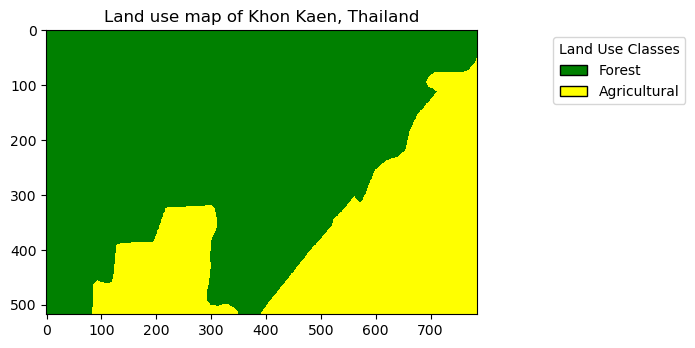

In [6]:
# Visualizing the Land use raster
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from rasterio.windows import from_bounds

%time

# Read the rasterized Land Use data within the bounding box
with rio.open(landuse_path) as src:
    window = from_bounds(*bbox, transform=src.transform)
    raster_data = src.read(1, window=window) #read just the 1st band
    crs = src.crs
     
print("Raster CRS:",crs) #check the coordinate reference system of the raster file
    
# Colors are assigned based on value / Landuse type
value_to_color = {
    1:'green',
    2:'yellow'}

# create a colormap with these values
colors = ['green', 'yellow']  # index 0 = value 1, index 1 = value 2
cmap = ListedColormap(colors)

# Create the visualization
plt.figure(figsize=(8, 8))
plt.imshow(raster_data, cmap=cmap, interpolation='none')

# Define legend labels
lu_legend = {1:'Forest',
             2:'Agricultural'}

# Add legend
legend_elements = [Patch(facecolor=color, edgecolor='black', label=lu_legend[value])
                   for value, color in value_to_color.items()]
plt.legend(handles=legend_elements, title="Land Use Classes", loc='upper right', bbox_to_anchor=(1.5, 1))

plt.title("Land use map of Khon Kaen, Thailand")

# Show the plot
plt.tight_layout()
plt.show()

## Stacking SPOT images and calculating spectral indices

This section processes SPOT images by:
- **Calculating spectral indices**:
  - **NDVI**: Measures vegetation health using the formula: `NDVI = (NIR - Red) / (NIR + Red)`.
  - **NDWI**: Detects water content using the formula: `NDWI = (Green - NIR) / (Green + NIR)`.
- **Multi-temporal stacking**: Combining SPOT images from 2022, 2020, and 2016, each with 6 bands (4 original + NDVI + NDWI), resulting in an 18-band composite image.

**Note**: This process may take up to 5 minutes depending on the image size and computational resources.

In [7]:
import glob
import rasterio
import numpy as np
from rasterio.windows import from_bounds

def calculate_indices(image_path, window=None):
    with rasterio.open(image_path) as src:
        if window:
            blue = src.read(1, window=window).astype(float)
            green = src.read(2, window=window).astype(float)
            red = src.read(3, window=window).astype(float)
            nir = src.read(4, window=window).astype(float)
        else:
            blue = src.read(1).astype(float)
            green = src.read(2).astype(float)
            red = src.read(3).astype(float)
            nir = src.read(4).astype(float)
        meta = src.meta
    ndvi = (nir - red) / (nir + red)
    ndwi = (green - nir) / (green + nir)
    return ndvi, ndwi, meta

def process_and_stack_images(folder_path, output_path, bbox):
    image_files = [
        os.path.join(folder_path, "img_SPOT2022A.tif"),
        os.path.join(folder_path, "img_SPOT2020A.tif"),
        os.path.join(folder_path, "img_SPOT2016A.tif")
    ]
    # Verify all images exist
    missing_files = [f for f in image_files if not os.path.exists(f)]
    if missing_files:
        raise FileNotFoundError(f"Missing images: {missing_files}")
    print(f"Processing images in order: {image_files}")
    all_bands = []
    first_transform = None
    for image_path in image_files:
        print(f"Processing {image_path}...")
        with rasterio.open(image_path) as src:
            window = from_bounds(*bbox, transform=src.transform)
            bands = [src.read(i, window=window) for i in [3, 2, 1, 4]]
            if not first_transform:
                first_transform = src.window_transform(window)
            if any(np.any(band == src.nodata) for band in bands):
                raise ValueError(f"No-data values found in {image_path}")
            meta = src.meta
        ndvi, ndwi, _ = calculate_indices(image_path, window=window)
        all_bands.extend(bands + [ndvi, ndwi])
    meta.update({
        'count': len(all_bands),
        'dtype': 'float32',
        'height': bands[0].shape[0],
        'width': bands[0].shape[1],
        'transform': first_transform,
        'compress': 'Deflate'
    })
    os.makedirs(os.path.dirname(os.path.abspath(output_path)), exist_ok=True)
    print(f"Saving stacked image to {output_path}...")
    with rasterio.open(output_path, 'w', **meta) as dst:
        for idx, band in enumerate(all_bands, start=1):
            dst.write(band.astype(np.float32), idx)
    print("Done with calculating and stacking all bands!")

# Define output path for the stacked image
%time
stacked_spot_image =os.path.join(output_folder,"stack.tif" ) # give file name to stack image
process_and_stack_images(spot_images_folder_path, stacked_spot_image, bbox)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.63 µs
Processing images in order: ['/home/jovyan/shared/2025_THA_LDD_training/SPOT/A/SPOT/img_SPOT2022A.tif', '/home/jovyan/shared/2025_THA_LDD_training/SPOT/A/SPOT/img_SPOT2020A.tif', '/home/jovyan/shared/2025_THA_LDD_training/SPOT/A/SPOT/img_SPOT2016A.tif']
Processing /home/jovyan/shared/2025_THA_LDD_training/SPOT/A/SPOT/img_SPOT2022A.tif...
Processing /home/jovyan/shared/2025_THA_LDD_training/SPOT/A/SPOT/img_SPOT2020A.tif...
Processing /home/jovyan/shared/2025_THA_LDD_training/SPOT/A/SPOT/img_SPOT2016A.tif...
Saving stacked image to Khon_Kaen/stack.tif...
Done with calculating and stacking all bands!


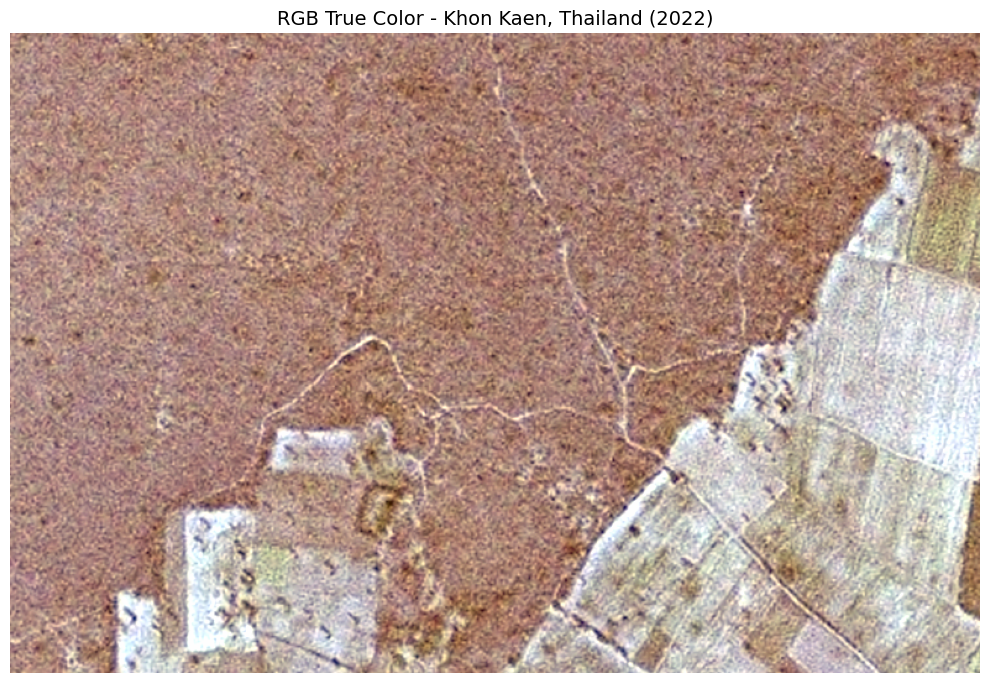

Interactive Exercise: Change the 'year' parameter to 2016 or 2020 and re-run the visualization. What differences do you observe in the RGB composite (e.g., changes in urban areas, vegetation, or water bodies)?


In [9]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.windows import from_bounds

def visualize_stack_image(stack_path, bbox, year=2022):
    """
    Visualize the RGB composite of the stacked SPOT image for a specific year.

    Parameters:
    - stack_path: Path to the stacked GeoTIFF file (18 bands).
    - bbox: Bounding box tuple (minx, miny, maxx, maxy) for the area of interest.
    - year: Year to visualize (2016, 2020, or 2022). Default is 2022.
    """
    # Validate input file
    if not os.path.exists(stack_path):
        raise FileNotFoundError(f"Stacked image not found: {stack_path}")

    with rasterio.open(stack_path) as src:
        # Check band count
        if src.count != 18:
            raise ValueError(f"Expected 18 bands, found {src.count}")

        # Define band indices for each year (1-based indexing in rasterio)
        year_indices = {
            2016: {'red': 3, 'green': 2, 'blue': 1},
            2020: {'red': 9, 'green': 8, 'blue': 7},
            2022: {'red': 15, 'green': 14, 'blue': 13}
        }

        if year not in year_indices:
            raise ValueError(f"Invalid year: {year}. Choose 2016, 2020, or 2022.")

        # Read RGB bands within the bounding box
        window = from_bounds(*bbox, transform=src.transform)
        red = src.read(year_indices[year]['red'], window=window).astype(float)
        green = src.read(year_indices[year]['green'], window=window).astype(float)
        blue = src.read(year_indices[year]['blue'], window=window).astype(float)

        # Get no-data value from metadata
        nodata = src.nodata if src.nodata is not None else 0  # Adjust based on your data

        # Normalize RGB bands for display
        def normalize_band(band):
            # Mask no-data values
            band = np.where(band == nodata, np.nan, band)
            # Clip to 99th percentile to avoid outliers
            band = np.clip(band, 0, np.nanpercentile(band, 99))
            # Normalize to 0-1 for visualization
            band_min, band_max = np.nanmin(band), np.nanmax(band)
            return (band - band_min) / (band_max - band_min + 1e-10) if band_max > band_min else band

        red_norm = normalize_band(red)
        green_norm = normalize_band(green)
        blue_norm = normalize_band(blue)

        # Create RGB composite
        rgb = np.dstack((red_norm, green_norm, blue_norm))

        # Create figure and plot RGB composite
        plt.figure(figsize=(10, 8))
        plt.imshow(rgb)
        plt.title(f"RGB True Color - Khon Kaen, Thailand ({year})", fontsize=14)
        plt.axis("off")
        plt.tight_layout()
        plt.show()

    # Interactive Exercise for Training
    print("Interactive Exercise: Change the 'year' parameter to 2016 or 2020 and re-run the visualization. What differences do you observe in the RGB composite (e.g., changes in urban areas, vegetation, or water bodies)?")

# Visualize the stacked image for 2022
stack_path = "/home/jovyan/shared/Arissara/Thai_Space/Materials_2classes/patch_112/Khon_Kaen/stack.tif"
bbox = (102.36639, 16.56754, 102.37659, 16.57427)
visualize_stack_image(stack_path, bbox, year=2022)

In [10]:
# Importing required libraries for cropping and patch creation
import rasterio as rio
from rasterio.mask import mask
from rasterio.windows import Window
from shapely.geometry import box
import geopandas as gpd
import os
import numpy as np
from tqdm import tqdm

## Cropping SPOT imagery to land use extent
This section crops the stacked SPOT imagery to match the spatial extent of the Land use data, ensuring that the imagery covers only the relevant study area. The output is an 18-band image aligned with the Land use raster.

## Creating Image and Label Patches
This section generates 224x224 pixel patches from both the SPOT imagery and Land use raster, ensuring correspondence between image and label patches for training.

In [11]:
# Clipping imagery to a reference extent
def clip_to_reference_extent(source_path, reference_path, output_path):
    """Clip the source image to the extent of the reference image."""
    print(f"Clipping {os.path.basename(source_path)} to reference extent...")
    with rio.open(reference_path) as ref:
        ref_bounds = ref.bounds
        ref_bbox = box(ref_bounds.left, ref_bounds.bottom, ref_bounds.right, ref_bounds.top)
        ref_gdf = gpd.GeoDataFrame({'geometry': [ref_bbox]}, crs=ref.crs)
    
    with rio.open(source_path) as src:
        ref_gdf = ref_gdf.to_crs(src.crs)
        out_image, out_transform = mask(src, ref_gdf.geometry, crop=True)
        out_meta = src.meta.copy()
        out_meta.update({
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })
        
        with rio.open(output_path, "w", **out_meta) as dest:
            dest.write(out_image)
    print("Clipping completed!")

In [12]:
# Creating random patches from SPOT and Land use data
def create_rm_patches(img_path, ann_path, img_output_dir, ann_output_dir, num_patches, patch_size=112, prefix="patch"):
    """Generate random patches from image and annotation rasters."""
    os.makedirs(img_output_dir, exist_ok=True)
    os.makedirs(ann_output_dir, exist_ok=True)
    
    with rio.open(img_path) as img, rio.open(ann_path) as ann:
        img_bands = img.count
        ann_bands = ann.count
        img_profile = img.profile
        ann_profile = ann.profile
        width, height = img.width, img.height

        for i in range(num_patches):
            x = np.random.randint(0, width - patch_size)
            y = np.random.randint(0, height - patch_size)
            print(f"Patch {i+1} Coordinates: ({x}, {y})")

            window = Window(x, y, patch_size, patch_size)
            img_patch_data = img.read(window=window)
            ann_patch_data = ann.read(window=window)

            img_output_path = os.path.join(img_output_dir, f'{prefix}_tile-{x:03d}-{y:03d}.tif')
            ann_output_path = os.path.join(ann_output_dir, f'{prefix}_tile-{x:03d}-{y:03d}.tif')
            img_profile.update({
                'width': patch_size,
                'height': patch_size,
                'transform': rio.windows.transform(window, img.transform)
            })
            ann_profile.update({
                'width': patch_size,
                'height': patch_size,
                'transform': rio.windows.transform(window, ann.transform)
            })

            with rio.open(img_output_path, 'w', **img_profile) as dst:
                dst.write(img_patch_data)
            with rio.open(ann_output_path, 'w', **ann_profile) as dst:
                dst.write(ann_patch_data)

In [13]:
# Processing images and creating patches
import os
import shutil

def process_images(landuse_path, spot_path, output_base_dir):
    """Clip Land Use to SPOT extent and create patches."""
    print("Starting image processing...")
    
    landuse_patches_dir = os.path.join(output_base_dir, 'landuse_patches')
    spot_patches_dir = os.path.join(output_base_dir, 'spot_patches')
    clipped_landuse_path = os.path.join(output_base_dir, 'clipped_landuse.tif')
    
    # Clip Land Use to SPOT extent
    clip_to_reference_extent(landuse_path, spot_path, clipped_landuse_path)
    
    # Create patches
    shutil.rmtree(landuse_patches_dir, ignore_errors=True)
    shutil.rmtree(spot_patches_dir, ignore_errors=True)
    create_rm_patches(spot_path, clipped_landuse_path, spot_patches_dir, landuse_patches_dir, 100)
    print("Image processing completed successfully!")

In [14]:
# Executing image processing
import shutil

process_images(
    landuse_path=landuse_path,
    spot_path=stacked_spot_image,
    output_base_dir=output_folder
)

Starting image processing...
Clipping gt_LU2022A_raster.tif to reference extent...
Clipping completed!
Patch 1 Coordinates: (533, 376)
Patch 2 Coordinates: (253, 141)
Patch 3 Coordinates: (436, 40)
Patch 4 Coordinates: (8, 106)
Patch 5 Coordinates: (275, 189)
Patch 6 Coordinates: (273, 69)
Patch 7 Coordinates: (569, 125)
Patch 8 Coordinates: (656, 104)
Patch 9 Coordinates: (300, 256)
Patch 10 Coordinates: (672, 386)
Patch 11 Coordinates: (348, 101)
Patch 12 Coordinates: (3, 5)
Patch 13 Coordinates: (165, 104)
Patch 14 Coordinates: (220, 364)
Patch 15 Coordinates: (550, 293)
Patch 16 Coordinates: (16, 123)
Patch 17 Coordinates: (389, 299)
Patch 18 Coordinates: (557, 243)
Patch 19 Coordinates: (522, 168)
Patch 20 Coordinates: (585, 104)
Patch 21 Coordinates: (119, 220)
Patch 22 Coordinates: (668, 117)
Patch 23 Coordinates: (149, 214)
Patch 24 Coordinates: (176, 244)
Patch 25 Coordinates: (216, 200)
Patch 26 Coordinates: (270, 136)
Patch 27 Coordinates: (442, 70)
Patch 28 Coordinates: (66

In [15]:
# Filtering patches to ensure correct dimensions
def filter_patch_images(image_folder):
    """Remove patches that do not match the desired size (112x112)."""
    desired_width, desired_height = 112, 112
    deleted_files = []
    image_files = [f for f in os.listdir(image_folder) if f.endswith('.tif')]
    
    for image_file in tqdm(image_files, desc="Processing Images", unit="image"):
        image_path = os.path.join(image_folder, image_file)
        try:
            with rio.open(image_path) as src:
                width, height = src.width, src.height
                if (width, height) != (desired_width, desired_height):
                    os.remove(image_path)
                    deleted_files.append(image_file)
        except Exception as e:
            print(f"Error processing {image_file}: {e}")
    
    print("\nSummary:")
    print(f"Total images processed: {len(image_files)}")
    print(f"Images deleted: {len(deleted_files)}")
    if deleted_files:
        print("Deleted files:")
        for file in deleted_files:
            print(f"- {file}")

# Filter SPOT and Land use patches
landuse_patch_folder = os.path.join(output_folder, 'landuse_patches')
spot_patch_folder = os.path.join(output_folder, 'spot_patches')
filter_patch_images(spot_patch_folder)
filter_patch_images(landuse_patch_folder)

Processing Images: 100%|██████████| 100/100 [00:00<00:00, 504.79image/s]



Summary:
Total images processed: 100
Images deleted: 0


Processing Images: 100%|██████████| 100/100 [00:00<00:00, 522.39image/s]


Summary:
Total images processed: 100
Images deleted: 0


## Splitting Data into Training, Validation, and Testing Sets

To support robust model development, the dataset is split into:
- **Training Set (70%)**: Used to train the model.
- **Validation Set (10%)**: Used to tune hyperparameters and monitor training performance.
- **Testing Set (20%)**: Used for final evaluation of the trained model on unseen data.

The split ensures that image and label patches remain paired across all sets.

In [16]:
# Splitting patches into training, validation, and testing sets
import os
import shutil
import random
import numpy as np

def create_train_val_test_splits(
    image_dir, 
    mask_dir, 
    output_dir,
    train_ratio=0.70,
    val_ratio=0.10,
    test_ratio=0.20,
    random_seed=42
):
    """Split image and mask patches into training, validation, and testing sets."""
    random.seed(random_seed)
    np.random.seed(random_seed)
    
    # Create directories for splits
    splits = ['train', 'val', 'test']
    for split in splits:
        for subdir in ['images', 'masks']:
            os.makedirs(os.path.join(output_dir, split, subdir), exist_ok=True)
    
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.tif')]
    random.shuffle(image_files)
    
    total_size = len(image_files)
    train_size = int(total_size * train_ratio)
    val_size = int(total_size * val_ratio)

    train_files = image_files[:train_size]
    val_files = image_files[train_size:train_size + val_size]
    test_files = image_files[train_size + val_size:]
    
    def copy_files(file_list, split_name):
        print(f"Copying {split_name} files...")
        for filename in file_list:
            src_image = os.path.join(image_dir, filename)
            dst_image = os.path.join(output_dir, split_name, 'images', filename)
            shutil.copy2(src_image, dst_image)
            src_mask = os.path.join(mask_dir, filename)
            dst_mask = os.path.join(output_dir, split_name, 'masks', filename)
            shutil.copy2(src_mask, dst_mask)
    
    split_files = {
        'train': train_files,
        'val': val_files,
        'test': test_files
    }
    
    for split_name, files in split_files.items():
        copy_files(files, split_name)
        print(f"{split_name} split: {len(files)} images")

    return {
        'train_size': len(train_files),
        'val_size': len(val_files),
        'test_size': len(test_files)
    }

# Create final training data directory and perform splitting
final_training_data_folder = os.path.join(output_folder, 'final_training_data')
shutil.rmtree(final_training_data_folder, ignore_errors=True)
os.makedirs(final_training_data_folder, exist_ok=True)

stats = create_train_val_test_splits(
    image_dir=spot_patch_folder,
    mask_dir=landuse_patch_folder,
    output_dir=final_training_data_folder,
    train_ratio=0.70,
    val_ratio=0.10,
    test_ratio=0.20,
    random_seed=42
)

print("\nData Split Summary:")
print(f"Total images: {sum(stats.values())}")
for split_name, size in stats.items():
    print(f"{split_name.capitalize()}: {size} images")

Copying train files...
train split: 70 images
Copying val files...
val split: 10 images
Copying test files...
test split: 20 images

Data Split Summary:
Total images: 100
Train_size: 70 images
Val_size: 10 images
Test_size: 20 images


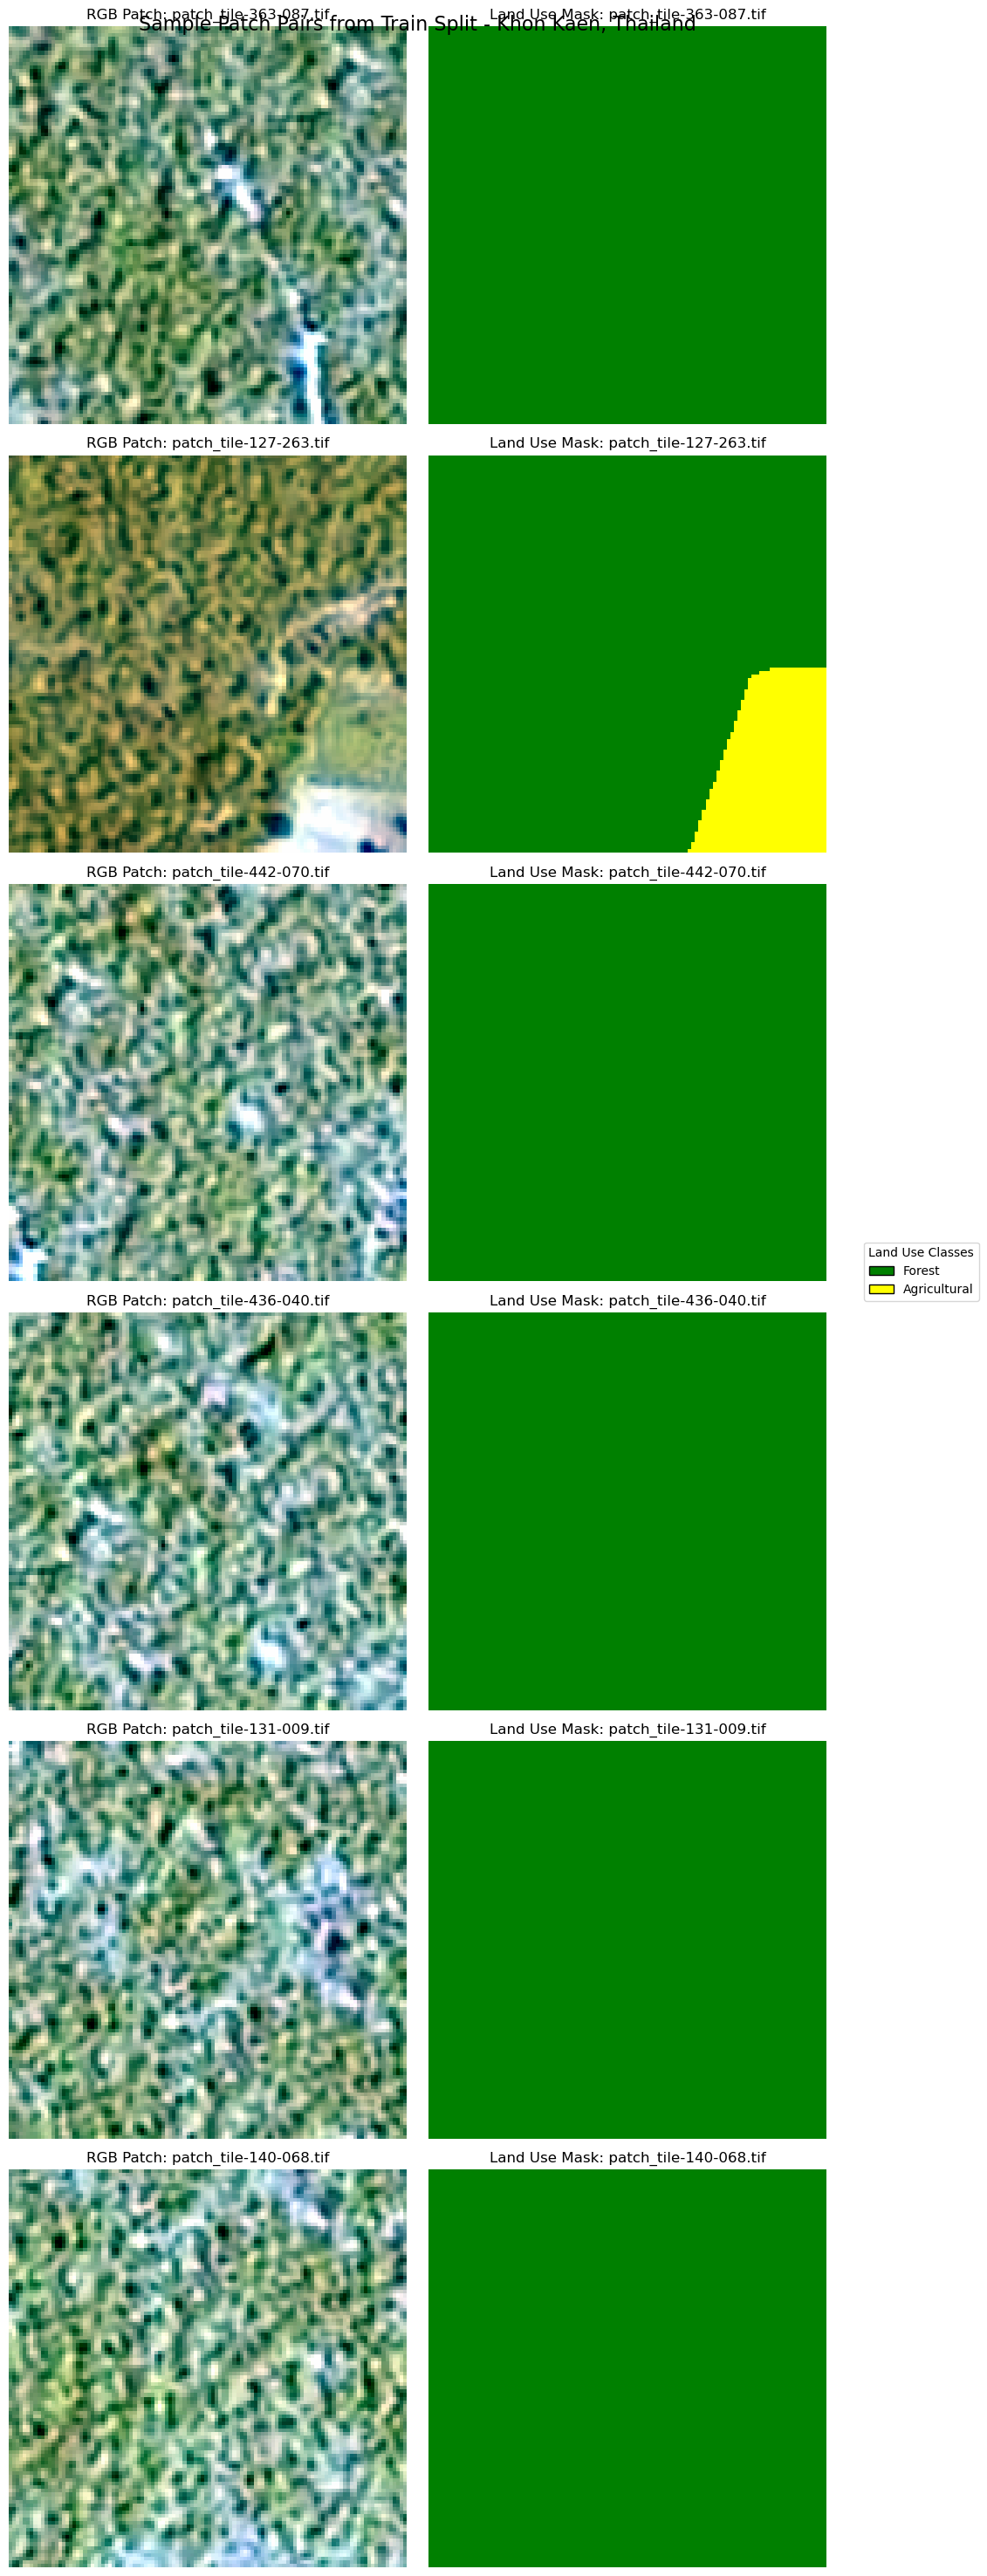

Interactive Exercise: Change the 'split' parameter to 'val' or 'test' and re-run the visualization. Do the patches look consistent across splits? How do the Land Use classes vary in different patches?


In [17]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import random
import os

def visualize_sample_patches(output_dir, split='train', num_samples=6, random_seed=42):
    """
    Visualize a few sample image and mask patch pairs from a specified split.

    Parameters:
    - output_dir: Path to the final training data directory (e.g., 'final_training_data').
    - split: Split to visualize ('train', 'val', or 'test'). Default is 'train'.
    - num_samples: Number of patch pairs to display. Default is 3.
    - random_seed: Random seed for reproducibility. Default is 42.
    """
    # Validate inputs
    if split not in ['train', 'val', 'test']:
        raise ValueError(f"Invalid split: {split}. Choose 'train', 'val', or 'test'.")
    image_dir = os.path.join(output_dir, split, 'images')
    mask_dir = os.path.join(output_dir, split, 'masks')
    
    if not os.path.exists(image_dir) or not os.path.exists(mask_dir):
        raise FileNotFoundError(f"Image or mask directory not found in {output_dir}/{split}")

    # Get list of image files
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.tif')]
    if len(image_files) < num_samples:
        raise ValueError(f"Requested {num_samples} samples, but only {len(image_files)} available in {split} split.")

    # Randomly select sample files
    random.seed(random_seed)
    sample_files = random.sample(image_files, num_samples)

    # Land Use class mapping and colors (from earlier notebook section)
    lu_classes = {
        1: 'Forest', 2: 'Agricultural'
    }
    lu_colors = {
        1: 'green', 2: 'yellow'
    }
    #cmap = ListedColormap([lu_colors[i] for i in range(1, 7)])
    cmap = ListedColormap([lu_colors[i] for i in sorted(lu_colors)])

    # Create figure for visualization
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))
    if num_samples == 1:
        axes = [axes]  # Ensure axes is iterable for single sample

    for i, filename in enumerate(sample_files):
        # Read image patch
        image_path = os.path.join(image_dir, filename)
        with rasterio.open(image_path) as src:
            if src.count < 3:
                raise ValueError(f"Image {filename} has fewer than 3 bands.")
            blue = src.read(1).astype(float)  # Band 1: Blue
            green = src.read(2).astype(float)  # Band 2: Green
            red = src.read(3).astype(float)  # Band 3: Red
            nodata = src.nodata if src.nodata is not None else 0

        # Normalize RGB bands for display
        def normalize_band(band):
            band = np.where(band == nodata, np.nan, band)
            band = np.clip(band, 0, np.nanpercentile(band, 99))  # Clip outliers
            band_min, band_max = np.nanmin(band), np.nanmax(band)
            return (band - band_min) / (band_max - band_min + 1e-10) if band_max > band_min else band

        red_norm = normalize_band(red)
        green_norm = normalize_band(green)
        blue_norm = normalize_band(blue)
        rgb = np.dstack((red_norm, green_norm, blue_norm))

        # Read mask patch
        mask_path = os.path.join(mask_dir, filename)
        with rasterio.open(mask_path) as src:
            if src.count != 1:
                raise ValueError(f"Mask {filename} should have 1 band, found {src.count}.")
            mask = src.read(1).astype(float)
            mask = np.where(mask == nodata, np.nan, mask)

        # Plot image and mask
        axes[i][0].imshow(rgb)
        axes[i][0].set_title(f"RGB Patch: {filename}")
        axes[i][0].axis('off')

        #mask_im = axes[i][1].imshow(mask, cmap=cmap, vmin=1, vmax=6)
        mask_im = axes[i][1].imshow(mask, cmap=cmap, vmin=1, vmax=len(lu_classes))
        axes[i][1].set_title(f"Land Use Mask: {filename}")
        axes[i][1].axis('off')

    # Add legend for Land Use classes
    legend_elements = [
        Patch(facecolor=lu_colors[i], edgecolor='black', label=lu_classes[i])
        for i in sorted(lu_classes)
    ]
    fig.legend(handles=legend_elements, title="Land Use Classes", loc='center right',
               bbox_to_anchor=(1.15, 0.5))

    plt.suptitle(f"Sample Patch Pairs from {split.capitalize()} Split - Khon Kaen, Thailand", fontsize=16)
    plt.tight_layout()
    plt.show()

    # Interactive Exercise for Training
    print("Interactive Exercise: Change the 'split' parameter to 'val' or 'test' and re-run the visualization. "
          "Do the patches look consistent across splits? How do the Land Use classes vary in different patches?")

# Visualize 3 sample patch pairs from the train split
final_training_data_folder = os.path.join(output_folder, 'final_training_data')
visualize_sample_patches(final_training_data_folder, split='train', num_samples=6, random_seed=42)